In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

In [49]:
def parse_conllu_grouped(file_path):
    """
    Parses a CoNLL-U file and groups forms and lemmas for each sentence.

    This function reads a CoNLL-U file and structures each sentence as a 
    single tuple. The tuple contains two lists: the first is a list of all 
    word forms in the sentence, and the second is a list of all their 
    corresponding lemmas.

    Args:
        file_path (str): The path to the .conllu file.

    Returns:
        list: A list of tuples. Each tuple represents a sentence and
              is structured as ([list_of_forms], [list_of_lemmas]).
              Returns an empty list if the file cannot be read.
    """
    all_sentences_grouped = []
    current_forms = []
    current_lemmas = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                # A blank line signifies the end of a sentence
                if line == '\n':
                    if current_forms:
                        # ONLY append the sentence if its length is 128 or less
                        if len(current_forms) <= 128:
                            sentence_tuple = (current_forms, current_lemmas)
                            all_sentences_grouped.append(sentence_tuple)
                        
                        # Always reset for the next sentence
                        current_forms = []
                        current_lemmas = []
                    continue

                # Ignore comment lines
                if line.startswith('#'):
                    continue

                columns = line.strip().split('\t')
                
                if len(columns) == 10:
                    token_id = columns[0]
                    # Process only single tokens, ignoring multiword/empty ones
                    if token_id.isdigit():
                        # Append form and lemma to their respective lists. can add more paramters from file with the desired index here
                        current_forms.append(columns[1])
                        current_lemmas.append(columns[3])

        # Add the very last sentence if it meets the length criteria
        if current_forms and len(current_forms) <= 128:
            sentence_tuple = (current_forms, current_lemmas)
            all_sentences_grouped.append(sentence_tuple)
            
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
        
    return all_sentences_grouped


In [50]:
# --- Example Usage ---

file_to_read = './UD_English-EWT-master/en_ewt-ud-train.conllu'
parsed_data_grouped = parse_conllu_grouped(file_to_read)

# Print the first two processed sentences to see the new structure
if parsed_data_grouped:
    print("Successfully parsed the file with the new structure.")
    
    # The first sentence
    print("\n--- First Sentence ---")
    sentence_one = parsed_data_grouped[0]
    print(f"Forms: {sentence_one[0]}")
    print(f"Lemmas: {sentence_one[1]}")
    
    # The second sentence
    print("\n--- Second Sentence ---")
    sentence_two = parsed_data_grouped[1]
    print(f"Forms: {sentence_two[0]}")
    print(f"Lemmas: {sentence_two[1]}")

Successfully parsed the file with the new structure.

--- First Sentence ---
Forms: ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']
Lemmas: ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']

--- Second Sentence ---
Forms: ['[', 'This', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']
Lemmas: ['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'AUX', 'AUX', 'VERB', 'PRON', 'NOUN', 'ADP', 'NOUN', 'PART', 'VERB', 'PUNCT', 'PUNCT']


In [51]:
def build_model(source_vectorizer, target_vectorizer, embedding_dim=128, lstm_units=64):
    """
    Builds and compiles a sequence-to-sequence Keras model with variable parameters.
    
    Args:
        source_vectorizer (TextVectorization): The adapted vectorizer for input forms.
        target_vectorizer (TextVectorization): The adapted vectorizer for target lemmas.
        embedding_dim (int): The dimensionality of the token embeddings.
        lstm_units (int): The number of units in the LSTM layer.
        
    Returns:
        keras.Model: A compiled Keras model.
    """
    SOURCE_VOCAB_SIZE = len(source_vectorizer.get_vocabulary())
    TARGET_VOCAB_SIZE = len(target_vectorizer.get_vocabulary())
    
    # 1. Input Layer - expecting a 1D tensor of strings
    inputs = Input(shape=(1,), dtype=tf.string, name="input_forms")
    
    # 2. Vectorization and Embedding
    x = source_vectorizer(inputs)
    x = Embedding(
        input_dim=SOURCE_VOCAB_SIZE, 
        output_dim=embedding_dim,
        mask_zero=True,
        name="embedding"
    )(x)
    
    # 3. Recurrent Layer
    x = Bidirectional(LSTM(lstm_units, return_sequences=True), name="bidirectional_lstm")(x)
    
    # 4. Output Layer
    outputs = TimeDistributed(
        Dense(TARGET_VOCAB_SIZE, activation="softmax"),
        name="output_lemmas"
    )(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

In [52]:
def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=32, model_path='best_model.keras'):
    """
    Trains the model and saves the best version.
    
    Args:
        model (keras.Model): The model to train.
        x_train, y_train: Training data and labels.
        x_val, y_val: Validation data and labels.
        epochs (int): Number of training epochs.
        batch_size (int): Size of the training batches.
        model_path (str): Path to save the best model.
        
    Returns:
        History: The training history object.
    """
    print(f"\n--- Starting Training for {epochs} Epochs ---")
    
    # Save the model with the best validation loss
    checkpoint = ModelCheckpoint(
        filepath=model_path,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint]
    )
    print("--- Training Finished ---")
    return history

def evaluate_model(model_path, x_test, y_test):
    """
    Loads the best saved model and evaluates it on the test set.
    """
    print(f"\n--- Evaluating Model: {model_path} ---")
    # Load the best model saved by the checkpoint
    best_model = keras.models.load_model(model_path)
    
    loss, accuracy = best_model.evaluate(x_test, y_test)
    print(f"Test Loss:     {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("--- Evaluation Finished ---")
    return loss, accuracy

def plot_history(history):
    """
    Plots training & validation accuracy and loss from a history object.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [53]:
# --- 1. Define Paths and Load Data 📂 ---
# Replace with your actual file names
train_file = './UD_English-EWT-master/en_ewt-ud-train.conllu'
val_file   = './UD_English-EWT-master/en_ewt-ud-dev.conllu'    # The dev set is typically used for validation
test_file  = './UD_English-EWT-master/en_ewt-ud-test.conllu'

print("Loading and parsing data from separate files...")
train_data_parsed = parse_conllu_grouped(train_file)
val_data_parsed   = parse_conllu_grouped(val_file)
test_data_parsed  = parse_conllu_grouped(test_file)
print("Data parsing complete.")

Loading and parsing data from separate files...
Data parsing complete.


In [54]:
# --- 3. Prepare Datasets and Train the Model ---

print("Creating and Preparing TensorFlow Datasets...")

# Define constants
BATCH_SIZE = 32
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 128

# Create vectorization layers
source_vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    name="source_vectorizer"
)

target_vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    name="target_vectorizer"
)

# Prepare the text data
train_forms = [" ".join(item[0]) for item in train_data_parsed]
train_lemmas = [" ".join(item[1]) for item in train_data_parsed]

val_forms = [" ".join(item[0]) for item in val_data_parsed]
val_lemmas = [" ".join(item[1]) for item in val_data_parsed]

test_forms = [" ".join(item[0]) for item in test_data_parsed]
test_lemmas = [" ".join(item[1]) for item in test_data_parsed]

# Adapt the vectorizers to the training data
print("\nAdapting vectorizers to the training data...")
source_vectorizer.adapt(train_forms)
target_vectorizer.adapt(train_lemmas)
print("Vectorizers adapted successfully.")

# Pre-vectorize the target lemmas
y_train_vec = target_vectorizer(train_lemmas)
y_val_vec = target_vectorizer(val_lemmas)
y_test_vec = target_vectorizer(test_lemmas)

# Create the TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_forms, y_train_vec))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_forms, y_val_vec))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_forms, y_test_vec))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nTensorFlow Datasets are ready.")
print(f"Training samples:   {len(train_forms)}")
print(f"Validation samples: {len(val_forms)}")
print(f"Test samples:       {len(test_forms)}")


Creating and Preparing TensorFlow Datasets...

Adapting vectorizers to the training data...
Vectorizers adapted successfully.

TensorFlow Datasets are ready.
Training samples:   12542
Validation samples: 2001
Test samples:       2077



==================== TESTING VARIANT: Small Model ====================


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_forms         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ source_vectorizer   │ (None, 128)       │          0 │ input_forms[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 64)   │    640,000 │ source_vectorize… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 128)       │          0 │ source_vectorize… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 128, 64)   │     24,832 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_lemmas       │ (None, 128, 19)   │      1,235 │ bidirectional_ls… │
│ (TimeDistributed)   │                   │            │ not_equal_3[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 666,067 (2.54 MB)

 Trainable params: 666,067 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.0432 - loss: 2.0840 - val_accuracy: 0.0437 - val_loss: 1.5790
Epoch 2/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.0580 - loss: 1.4963 - val_accuracy: 0.0499 - val_loss: 1.2902
Epoch 3/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.0645 - loss: 1.2621 - val_accuracy: 0.0507 - val_loss: 1.2124
Epoch 4/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.0687 - loss: 1.1217 - val_accuracy: 0.0511 - val_loss: 1.1857
Epoch 5/5
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.0723 - loss: 1.0176 - val_accuracy: 0.0511 - val_loss: 1.1866


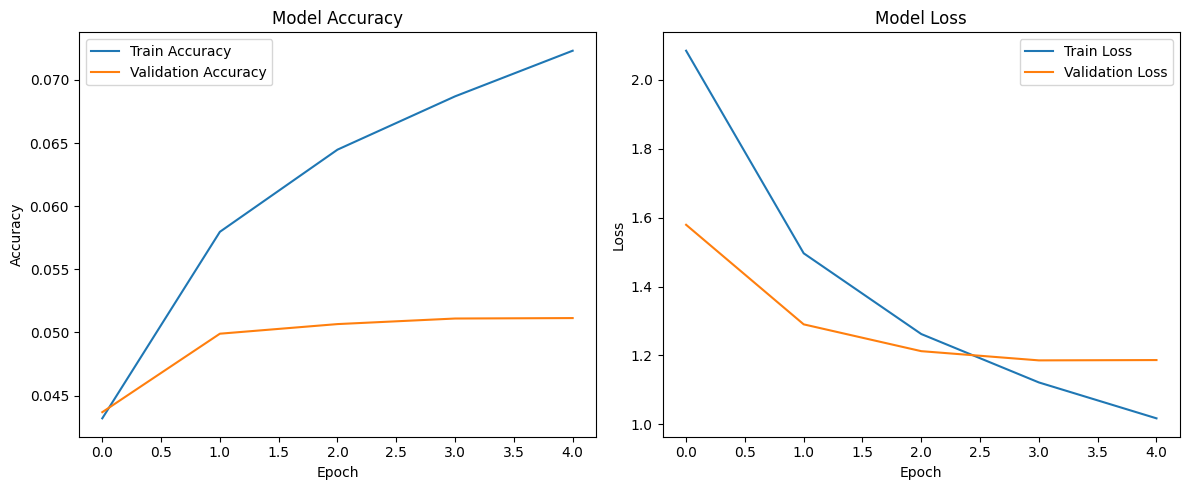


--- Evaluating Model: best_model.keras ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0487 - loss: 1.1736
Test Loss:     1.1736
Test Accuracy: 0.0487
--- Evaluation Finished ---


In [55]:

# --- 4. Build, Train, and Evaluate the Model ---

# Define model configuration
model_config = {"name": "Small Model", "embedding_dim": 64, "lstm_units": 32}

print(f"\n{'='*20} TESTING VARIANT: {model_config['name']} {'='*20}")

# Build the model
model = build_model(
    source_vectorizer,
    target_vectorizer,
    embedding_dim=model_config["embedding_dim"],
    lstm_units=model_config["lstm_units"]
)
model.summary()

# Train the model
model_path = "best_model.keras"
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')]
)

# Plot the training history
plot_history(history)

# Evaluate the best model
print(f"\n--- Evaluating Model: {model_path} ---")
best_model = keras.models.load_model(model_path)
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("--- Evaluation Finished ---")